BINET Performance
==

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.basics import *
from pympp.process import *
from pympp.anomaly.detect import *
from pympp.anomaly.heuristics import *
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
import seaborn as sns
from fastai.tabular.model import get_emb_sz
from bayes_opt import BayesianOptimization


## Load Logs and Models

In [ ]:
logs = [Path(fn).stem[:-4] for fn in progress_bar(glob.glob(f'../data/logs/csv/dapnn_ds/binet_logs/*'))]
len(logs)

40

In [ ]:
learner_path=f'models/binet_logs/'

In [ ]:
def load_pred_model(learner_path,train_log_path,log_name,cols=['activity']):
    p = f'{learner_path}/{log_name}_vocab.p'
    with open(p, 'rb') as fp:
        categorify = pickle.load(fp)
    log = import_log(train_log_path)
    o = process_test(log,categorify,cols)
    dls=o.get_dls()
    loss=partial(multi_loss_sum,o)
    emb_szs = get_emb_sz(o)
    m=MultivariateModel(emb_szs)
    learn=Learner(dls, m, path=learner_path, model_dir='.', loss_func=loss, metrics=get_metrics(o))
    learn.load(log_name,with_opt=False)
    m=learn.model.cuda()
    return m, categorify


def multivariate_anomaly_score(res,o,idx,cols):
    score_df=pd.DataFrame()

    for cidx,_ in enumerate(cols):
        sm = nn.Softmax(dim=1)
        p = sm(res[cidx].cpu())
        pred = p.max(1)[0]
        y = o.items[cols[cidx]].iloc[idx].values

        truth=p[list(range(len(y))),y]
        score = ((pred - truth) / pred).tolist()
        score_df[cols[cidx]] = score
    score_df['trace_id']=o.items.index.to_series().iloc[idx].values
    return score_df


In [ ]:
def get_score_df(log_name):
    fn=f'./data/logs/csv/dapnn_ds/binet_logs/{log_name}.csv.gz'
    cols= get_attr(attr_dict,log_name)
    training_log_path=f'./data/logs/csv/dapnn_ds/binet_logs/{log_name}.csv.gz'
    m2, categorify = load_pred_model(learner_path,training_log_path,log_name,cols=cols)
    log = import_log(fn,cols)
    o = process_test(log,categorify,cols)
    res,idx=predict_next_step(o,m2)
    score_df=multivariate_anomaly_score(res,o,idx,cols)
    return score_df,cols,o

In [ ]:
log_name= 'bpic15-0.3-4'
score_df,cols,o = get_score_df(log_name)


/tmp/ipykernel_3414969/1108395208.py:2: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  score_df,cols,o = get_score_df(log_name)
/home/lahann/mambaforge/envs/pympp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
max_error_cases = score_df.groupby('trace_id').max()
y_true =o.items.groupby(o.items.index)['anomaly'].last().to_numpy() != 'normal'


In [ ]:
all_cols = np.unique([i for j in attr_dict.values() for i in j ])

##  Best Heuristic - Bayesian Optimization

In [ ]:
all_cols =['activity', 'user', 'day', 'country', 'company','org:resource',]

In [ ]:
def optimize(**settings):
    y_pred =(np.array([(max_error_cases[c]>settings[c]).tolist() for c in cols]).max(axis=0))   
    return (f1_score(y_pred,y_true))

# Bounded region of parameter space
pbounds = {c:(0.9,1.0) for c in cols}


In [ ]:
# Only run this if you want to recreate the best_th_df, takes arround 3h
res = []
n_iter = 500

for log_name in progress_bar(logs):
    score_df,cols,o = get_score_df(log_name)
    max_error_cases = score_df.groupby('trace_id').max()
    y_true =o.items.groupby(o.items.index)['anomaly'].last().to_numpy() != 'normal'
    pbounds = {c:(0.8,1.0) for c in cols}

    optimizer = BayesianOptimization(
        f=optimize,
        pbounds=pbounds,
        verbose=0,
        random_state=1,
    )
    optimizer.maximize(init_points=20, n_iter=n_iter) 
    res.append([log_name,optimizer.max['target']]+
               [optimizer.max['params'][c] if c in cols else 0.0 for c in all_cols ])


/tmp/ipykernel_3414969/1864857608.py:4: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  score_df,cols,o = get_score_df(log_name)
/tmp/ipykernel_3414969/1864857608.py:4: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  score_df,cols,o = get_score_df(log_name)
/home/lahann/mambaforge/envs/pympp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_3414969/1864857608.py:4: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  score_df,cols,o = get_score_df(log_name)
/home/lahann/mambaforge/envs/pympp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=Fa

In [ ]:
best_th_df = pd.DataFrame(res,columns=['log_name','best F1 Score',*all_cols])
best_th_df

,log_name,best F1 Score,activity,user,day,country,company,org:resource
0,bpic15-0.3-4,0.451471,0.944065,0.000000,0.000000,0.000000,0.000000,0.818468
1,large-0.3-4,0.937398,0.940005,1.000000,1.000000,0.999750,0.981446,0.000000
2,small-0.3-4,0.961668,0.873245,1.000000,1.000000,0.931696,1.000000,0.000000
3,bpic13-0.3-3,0.419858,0.824835,0.000000,0.000000,0.000000,0.000000,0.993919
4,medium-0.3-3,0.930289,0.823992,0.972513,0.964294,0.960638,0.000000,0.000000
5,medium-0.3-1,0.975855,0.960149,0.993652,0.000000,0.000000,0.000000,0.000000
6,bpic17-0.3-1,0.484787,0.893105,0.000000,0.000000,0.000000,0.000000,1.000000
7,wide-0.3-3,0.926388,0.847682,1.000000,0.946180,0.995507,0.000000,0.000000
8,large-0.3-2,0.951917,0.950029,0.949633,0.997772,0.000000,0.000000,0.000000
9,bpic17-0.3-2,0.838753,0.884222,0.000000,0.000000,0.000000,0.000000,0.991578


##  Other Heuristics


In [ ]:
def multi_attr_f1_score(y_true,max_error_cases,ths):
    y_pred =(np.array([(max_error_cases[c]>ths[c]).tolist() for c in cols]).max(axis=0))   
    return f1_score(y_pred,y_true)


In [ ]:
def threshold_anomaly_ratio_df(max_error_cases,min_th= 0.0):
    res = []
    for col in cols:
        ths = max_error_cases[col].unique()
        ths = ths[ths >min_th]
        r = np.array([sum(max_error_cases[col] >th) for th in ths])/len(max_error_cases)
        res+=zip(ths,r,[col]*len(ths))
    return pd.DataFrame(res,columns=['Th','Anomaly Ratio','Col']) 

def threshold_anomaly_ratio_df_fixed(max_error_cases):
    ths =np.arange(100)*0.001+0.9
    res=[]
    for col in cols:
        r = np.array([sum(max_error_cases[col] >th) for th in ths])/len(max_error_cases)
        res+=zip(ths,r,[col]*len(ths))
    return pd.DataFrame(res,columns=['Th','Anomaly Ratio','Col']) 


In [ ]:
heuristics = [partial(get_ratio_th,0.5),elbow_heuristic,
              partial(get_fixed_heuristic,0.98),get_lowest_plateau_heuristic]
heuristic_names = ['r_0.5','e_down','e_up','fix','lp_min','lp_mean','lp_max']

In [ ]:
log_name='paper-0.3-1'

score_df,cols,o = get_score_df(log_name)
max_error_cases = score_df.groupby('trace_id').max()
y_true =o.items.groupby(o.items.index)['anomaly'].last().to_numpy() != 'normal'
df =threshold_anomaly_ratio_df_fixed(max_error_cases)
multi_attr_f1_score(y_true,max_error_cases,{'activity':0.945,'user':0.984})

0.9962341663813762

In [ ]:
get_lowest_plateau_heuristic(df[df['Col']=='user'])

(Th                0.985
 Anomaly Ratio    0.1862
 Col                user
 Name: 185, dtype: object,
 Th                0.985
 Anomaly Ratio    0.1862
 Col                user
 Name: 185, dtype: object,
 Th                0.985
 Anomaly Ratio    0.1862
 Col                user
 Name: 185, dtype: object)

In [ ]:
test = df[df['Col']=='activity'].copy()
test.index = test['Th']

In [ ]:
get_lowest_plateau_heuristic(test)

(Th                  0.901
 Anomaly Ratio      0.2462
 Col              activity
 Name: 0.901, dtype: object,
 Th                  0.944
 Anomaly Ratio      0.2462
 Col              activity
 Name: 0.9440000000000001, dtype: object,
 Th                  0.988
 Anomaly Ratio      0.2462
 Col              activity
 Name: 0.988, dtype: object)

In [ ]:
log_name='paper-0.3-1'
score_df,cols,o = get_score_df(log_name)
max_error_cases = score_df.groupby('trace_id').max()
y_true =o.items.groupby(o.items.index)['anomaly'].last().to_numpy() != 'normal'
df =threshold_anomaly_ratio_df_fixed(max_error_cases)
#df =threshold_anomaly_ratio_df(max_error_cases)

h_ths = {col:[i for j in [[k.Th for k in listify(h(df[df['Col']==col]))] for h in heuristics] for i in j] for col in cols}
h_ths_df = pd.DataFrame(h_ths,index=heuristic_names).transpose()
h_ths_df['Log'] = log_name
h_ths_df

,r_0.5,e_down,e_up,fix,lp_min,lp_mean,lp_max,Log
activity,0.9,0.992,0.990,0.901,0.901,0.944,0.988,paper-0.3-1
user,0.9,0.912,0.911,0.900,0.985,0.985,0.985,paper-0.3-1


In [ ]:
f1_scores={h:multi_attr_f1_score(y_true,max_error_cases,h_ths_df[h]) for h in heuristic_names}
f1_scores

{'r_0.5': 0.8982219497240956,
 'e_down': 0.9602836879432624,
 'e_up': 0.8998459167950694,
 'fix': 0.8982219497240956,
 'lp_min': 0.9962341663813762,
 'lp_mean': 0.9962341663813762,
 'lp_max': 0.9962341663813762}

In [ ]:
res = []
res_ths = []
for log_name in progress_bar(logs):
    score_df,cols,o = get_score_df(log_name)
    max_error_cases = score_df.groupby('trace_id').max()
    y_true =o.items.groupby(o.items.index)['anomaly'].last().to_numpy() != 'normal'
    df =threshold_anomaly_ratio_df_fixed(max_error_cases)
    #df =threshold_anomaly_ratio_df(max_error_cases)
    h_ths = {col:[i for j in [[k.Th for k in listify(h(df[df['Col']==col]))] for h in heuristics] for i in j] for col in cols}
    h_ths_df = pd.DataFrame(h_ths,index=heuristic_names).transpose()
    h_ths_df['Log'] = log_name
    res_ths+=h_ths_df.values.tolist()

    f1_scores={h:multi_attr_f1_score(y_true,max_error_cases,h_ths_df[h]) for h in heuristic_names}
    f1_scores['Log']= log_name
    res.append(f1_scores)
heuristic_th_df = pd.DataFrame(res)
heuristic_th_df

/tmp/ipykernel_3414969/2538357640.py:4: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  score_df,cols,o = get_score_df(log_name)
/home/lahann/mambaforge/envs/pympp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_3414969/2538357640.py:4: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  score_df,cols,o = get_score_df(log_name)
/home/lahann/mambaforge/envs/pympp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_3414969/2538357640.py:4: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_

,r_0.5,e_down,e_up,fix,lp_min,lp_mean,lp_max,Log
0,0.469136,0.470405,0.450185,0.451471,0.469498,0.469498,0.469498,bpic15-0.3-4
1,0.683812,0.768873,0.912346,0.683812,0.907368,0.907923,0.908979,large-0.3-4
2,0.709933,0.950145,0.943371,0.709933,0.943084,0.943084,0.943084,small-0.3-4
3,0.391753,0.395604,0.397590,0.377088,0.421603,0.421603,0.419580,bpic13-0.3-3
4,0.781832,0.797542,0.830393,0.781832,0.870879,0.870879,0.870879,medium-0.3-3
5,0.891285,0.881666,0.912883,0.891285,0.936762,0.936674,0.935889,medium-0.3-1
6,0.544370,0.468426,0.525774,0.459481,0.459481,0.459481,0.461569,bpic17-0.3-1
7,0.758085,0.916066,0.806943,0.758085,0.889936,0.889936,0.890236,wide-0.3-3
8,0.809877,0.892727,0.876196,0.809877,0.978667,0.978667,0.978667,large-0.3-2
9,0.694332,0.669278,0.858127,0.670450,0.668974,0.668974,0.668974,bpic17-0.3-2


In [ ]:
heuristic_th_df.describe()

,r_0.5,e_down,e_up,fix,lp_min,lp_mean,lp_max
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.721312,0.767954,0.778746,0.713463,0.814458,0.814513,0.814571
std,0.153024,0.188515,0.189436,0.163644,0.201974,0.202089,0.202227
min,0.391753,0.395604,0.397590,0.377088,0.421603,0.421603,0.419580
25%,0.639520,0.668069,0.654730,0.627319,0.684625,0.682983,0.680265
50%,0.764245,0.838294,0.858163,0.764245,0.923210,0.923649,0.924724
75%,0.849058,0.912828,0.912480,0.849058,0.960176,0.960176,0.960176
max,0.913346,0.991741,0.995289,0.913346,0.996234,0.996234,0.996234


In [ ]:
heuristic_th_df['best']=best_th_df['best F1 Score']

In [ ]:
ds=['BPIC12','BPIC13','BPIC15','BPIC17','Paper','P2P','Small','Medium','Large','Huge','Gigantic','Wide']

df =pd.DataFrame([heuristic_th_df[heuristic_th_df['Log'].str.contains(i.lower())].mean() for i in ds],index = ds)
res_binet_df = df.copy().T
res_binet_df

,BPIC12,BPIC13,BPIC15,BPIC17,Paper,P2P,Small,Medium,Large,Huge,Gigantic,Wide
r_0.5,0.659213,0.443594,0.482717,0.619351,0.898222,0.843374,0.844985,0.815860,0.748341,0.777190,0.739462,0.808780
e_down,0.694447,0.439140,0.466954,0.568852,0.960284,0.936781,0.943588,0.847611,0.811015,0.848674,0.764254,0.916465
e_up,0.721668,0.443249,0.459558,0.691950,0.899846,0.910137,0.944600,0.874679,0.828978,0.889191,0.806030,0.875606
fix,0.620128,0.427341,0.458533,0.564966,0.898222,0.843374,0.844985,0.816885,0.748341,0.777190,0.739329,0.808780
lp_min,0.689842,0.465680,0.476808,0.564228,0.996234,0.968649,0.971037,0.906670,0.946018,0.946225,0.810518,0.946557
lp_mean,0.687652,0.465680,0.476808,0.564228,0.996234,0.968640,0.971611,0.906648,0.946446,0.946359,0.810518,0.946557
lp_max,0.684029,0.465006,0.476874,0.565271,0.996234,0.968969,0.971611,0.906696,0.946913,0.946806,0.810538,0.946632
best,0.717622,0.457859,0.458533,0.661770,0.999659,0.977054,0.965965,0.943423,0.942218,0.900181,0.902095,0.941210


In [ ]:
df['Log']=df.index


In [ ]:
def get_plot_data(th_df):
    plot_data=th_df.melt(var_name='Heuristic',value_name='F1 Score',id_vars = ['Log'],value_vars=['r_0.5',
 'e_down',
 'e_up',
 'fix',
 'lp_min',
 'lp_mean',
 'lp_max',
 'best',],ignore_index=False)
    plot_data.index=range(len(plot_data))
    return plot_data
plot_data = get_plot_data(df)

In [ ]:
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
plt.style.use('ggplot')

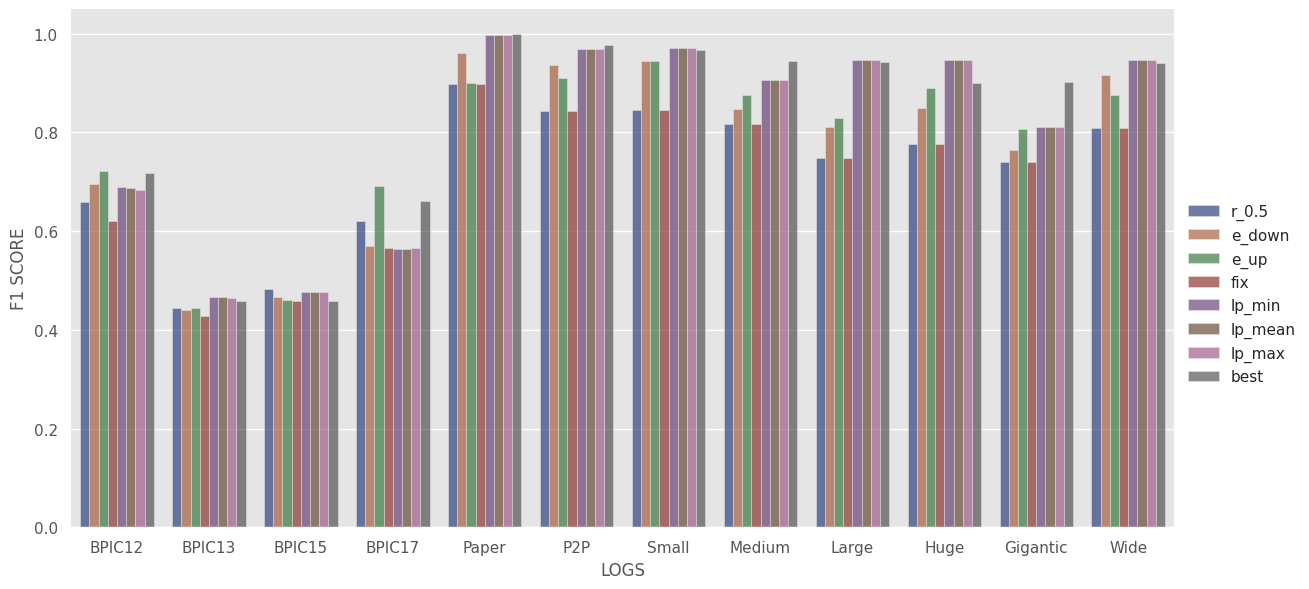

In [ ]:

g = sns.catplot(
    data=plot_data, kind="bar",
    x="Log", y="F1 Score", hue="Heuristic",
    errorbar="sd", palette="dark", alpha=.6, height=6,aspect=2
)
g.despine(left=True)
g.set_axis_labels("LOGS", "F1 SCORE")
plt.xticks(rotation = 0)
g.legend.set_title("")

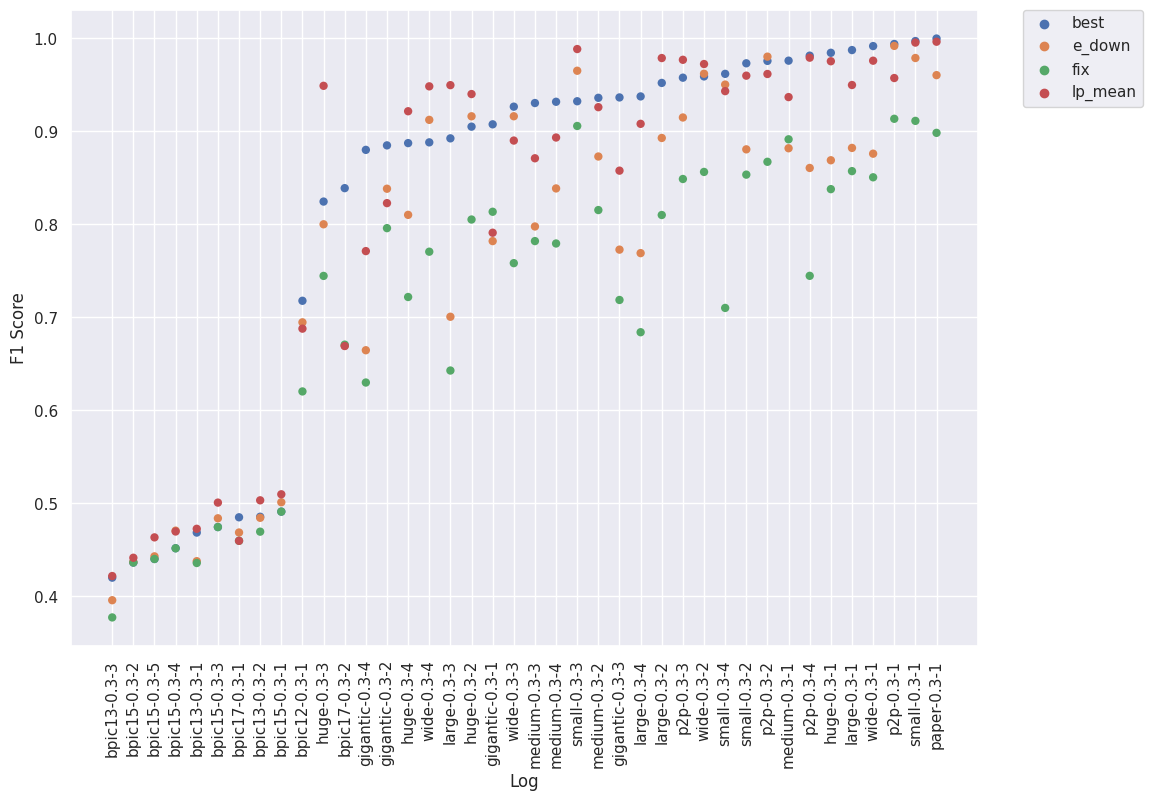

In [ ]:
binet_synth_df =heuristic_th_df.sort_values('best')

def get_plot_data(th_df,id_vars=['Log Name'],value_vars = ['F1 Score','Anomaly Ratio']):
    plot_data=th_df.melt(var_name='Heuristic',value_name='Score',id_vars =id_vars ,value_vars=value_vars,ignore_index=False)
    plot_data['Threshold']=plot_data.index
    plot_data.index=range(len(plot_data))
    return plot_data

plot_data = get_plot_data(binet_synth_df,id_vars=['Log'],value_vars=['best',
 'e_down',
 'fix',
 'lp_mean',
])


log2int = {j:i for i,j in enumerate(binet_synth_df['Log'].unique())}
plot_data ['Log']= plot_data['Log'].map(log2int)
plot_data ['F1 Score']=plot_data ['Score']

sns.set(rc={'figure.figsize':(11.7,8.27)})

g=sns.scatterplot(data =plot_data, x='Log',y='F1 Score', hue='Heuristic' ,linewidth=0,)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticks(range(len(binet_synth_df)));
g.set_xticklabels(binet_synth_df['Log'].unique(),rotation = 90);


## Anomaly Types

In [ ]:
h_ths_df['lp_mean']

activity    0.986
user        0.985
day         0.987
country     0.985
company     0.981
Name: lp_mean, dtype: float64

In [ ]:
log_name = 'large-0.3-4'
score_df,cols,o = get_score_df(log_name)
max_error_cases = score_df.groupby('trace_id').max()
y_true =o.items.groupby(o.items.index)['anomaly'].last().to_numpy() != 'normal'
df =threshold_anomaly_ratio_df_fixed(max_error_cases)
h_ths = {col:[i for j in [[k.Th for k in listify(h(df[df['Col']==col]))] for h in heuristics] for i in j] for col in cols}
h_ths_df = pd.DataFrame(h_ths,index=heuristic_names).transpose()
ths = h_ths_df['lp_mean']
y_pred =(np.array([(max_error_cases[c]>ths[c]).tolist() for c in cols]).max(axis=0))   
k=o.items.groupby(o.items.index)['anomaly'].last().iloc[np.where(np.equal(y_pred, y_true))[0]]
k.value_counts()

normal          3215
Early            267
Insert           262
SkipSequence     259
Rework           251
Late             239
Attribute        206
Name: anomaly, dtype: int64

In [ ]:
k=o.items.groupby(o.items.index)['anomaly'].last().iloc[np.where(~np.equal(y_pred, y_true))[0]]
k.value_counts()
multi_attr_f1_score(y_true,max_error_cases,ths.to_dict())

0.9079229122055674

In [ ]:
ths

activity    0.981
user        0.978
day         0.984
country     0.984
company     0.975
Name: lp_mean, dtype: float64

In [ ]:
best_th_df

,log_name,best F1 Score,activity,user,day,country,company,org:resource
0,bpic15-0.3-4,0.451471,0.944065,0.000000,0.000000,0.000000,0.000000,0.818468
1,large-0.3-4,0.937398,0.940005,1.000000,1.000000,0.999750,0.981446,0.000000
2,small-0.3-4,0.961668,0.873245,1.000000,1.000000,0.931696,1.000000,0.000000
3,bpic13-0.3-3,0.419858,0.824835,0.000000,0.000000,0.000000,0.000000,0.993919
4,medium-0.3-3,0.930289,0.823992,0.972513,0.964294,0.960638,0.000000,0.000000
5,medium-0.3-1,0.975855,0.960149,0.993652,0.000000,0.000000,0.000000,0.000000
6,bpic17-0.3-1,0.484787,0.893105,0.000000,0.000000,0.000000,0.000000,1.000000
7,wide-0.3-3,0.926388,0.847682,1.000000,0.946180,0.995507,0.000000,0.000000
8,large-0.3-2,0.951917,0.950029,0.949633,0.997772,0.000000,0.000000,0.000000
9,bpic17-0.3-2,0.838753,0.884222,0.000000,0.000000,0.000000,0.000000,0.991578


In [ ]:
anomalie_types = []

for log_name in progress_bar(logs):
    score_df,cols,o = get_score_df(log_name)
    max_error_cases = score_df.groupby('trace_id').max()
    y_true =o.items.groupby(o.items.index)['anomaly'].last().to_numpy() != 'normal'
    df =threshold_anomaly_ratio_df_fixed(max_error_cases)
    h_ths = {col:[i for j in [[k.Th for k in listify(h(df[df['Col']==col]))] for h in heuristics] for i in j] for col in cols}
    h_ths_df = pd.DataFrame(h_ths,index=heuristic_names).transpose()
    for hn in heuristic_names:
        ths =h_ths_df[hn]
        y_pred =(np.array([(max_error_cases[c]>ths[c]).tolist() for c in cols if c in all_cols]).max(axis=0))   
        k=o.items.groupby(o.items.index)['anomaly'].last().iloc[np.where(np.equal(y_pred, y_true))[0]]
        k= k.value_counts().to_dict()
        k['heuristic']=hn
        k['log_name'] = log_name
        k['correct']=True
        anomalie_types.append(k)
        k=o.items.groupby(o.items.index)['anomaly'].last().iloc[np.where(~np.equal(y_pred, y_true))[0]]
        k= k.value_counts().to_dict()
        k['log_name'] = log_name
        k['correct']=False
        k['heuristic']=hn
        anomalie_types.append(k)
    settings = best_th_df[best_th_df['log_name']==log_name].iloc[0][2:]
    y_pred =(np.array([(max_error_cases[c]>settings[c]).tolist() for c in cols if c in all_cols]).max(axis=0))  
    k=o.items.groupby(o.items.index)['anomaly'].last().iloc[np.where(np.equal(y_pred, y_true))[0]]
    k= k.value_counts().to_dict()
    k['heuristic']='best'
    k['log_name'] = log_name
    k['correct']=True
    anomalie_types.append(k)
    k=o.items.groupby(o.items.index)['anomaly'].last().iloc[np.where(~np.equal(y_pred, y_true))[0]]
    k= k.value_counts().to_dict()
    k['log_name'] = log_name
    k['correct']=False
    k['heuristic']='best'
    anomalie_types.append(k)


/tmp/ipykernel_3414969/612902554.py:4: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  score_df,cols,o = get_score_df(log_name)
/home/lahann/mambaforge/envs/pympp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_3414969/612902554.py:4: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  score_df,cols,o = get_score_df(log_name)
/home/lahann/mambaforge/envs/pympp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_3414969/612902554.py:4: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_mem

In [ ]:
anomalie_types= pd.DataFrame(anomalie_types)
anomalie_types.fillna(0,inplace=True)

In [ ]:
1- (anomalie_types[(anomalie_types['heuristic']=='lp_mean')&(anomalie_types['correct']==False)]['Early'].sum() / 
anomalie_types[(anomalie_types['heuristic']=='lp_mean')]['Early'].sum())

0.8302284140612344

In [ ]:
anomalie_types[(anomalie_types['heuristic']=='lp_mean')]['Early'].sum()

12346.0

In [ ]:
anomalie_types_bpi = anomalie_types[anomalie_types['log_name'].str.contains('bpi')]
anomalie_types_synth = anomalie_types[~anomalie_types['log_name'].str.contains('bpi')]


In [ ]:
heuristics_desc = ['Best','Elbow↓','Elbow↑','Fix-98','LP-Max','LP-Mean','LP-Min','AR-0.5']


In [ ]:
anomalie_types = anomalie_types_bpi
anomalie_types_ratio =(anomalie_types[anomalie_types['correct']==False].groupby(['heuristic'])[anomalie_types.columns[:-3]].sum()
/ anomalie_types.groupby(['heuristic'])[anomalie_types.columns[:-3]].sum())
anomalie_types_ratio = 1 - (anomalie_types_ratio)

anomalie_types_ratio['Heuristic']=anomalie_types_ratio.index
anomalie_types_ratio['Normal']=anomalie_types_ratio['normal']
anomalie_types_ratio['Heuristic'] = heuristics_desc
anomalie_types_ratio

,normal,Attribute,Rework,Late,Insert,SkipSequence,Early,Heuristic,Normal
heuristic,,,,,,,,,
best,0.645508,0.676679,0.974893,0.915004,1.000000,0.946477,0.927695,Best,0.645508
e_down,0.400341,0.890186,0.978396,0.907023,1.000000,0.981132,0.871692,Elbow↓,0.400341
e_up,0.624262,0.743447,0.932269,0.940942,0.999808,0.932807,0.942846,Elbow↑,0.624262
fix,0.325507,0.918883,0.992799,0.989824,1.000000,0.994417,0.992520,Fix-98,0.325507
lp_max,0.479932,0.854601,0.821331,0.726457,0.999424,0.931267,0.738013,LP-Max,0.479932
lp_mean,0.476992,0.854792,0.823472,0.727454,0.999424,0.932807,0.739164,LP-Mean,0.476992
lp_min,0.476826,0.855366,0.824835,0.728053,0.999424,0.933577,0.739356,LP-Min,0.476826
r_0.5,0.528791,0.877559,0.958155,0.956504,1.000000,0.955333,0.963368,AR-0.5,0.528791


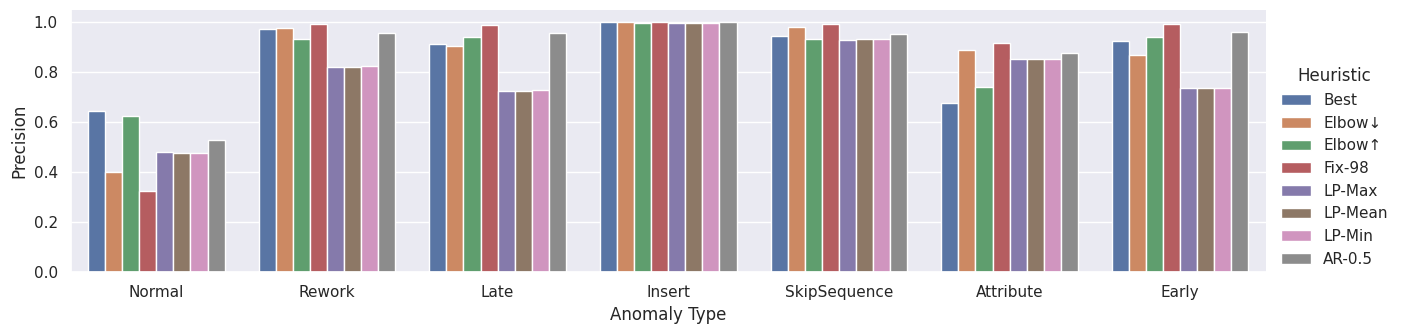

In [ ]:
color_palette = sns.color_palette()
df = anomalie_types_ratio.melt(var_name='Anomaly Type',value_name='Precision',id_vars ='Heuristic',value_vars=['Normal',
 'Rework',
 'Late',
 'Insert',
 'SkipSequence',
 'Attribute',
 'Early'],ignore_index=False)
g = sns.catplot(x="Anomaly Type", y="Precision",palette=color_palette,
                data=df, kind="bar",hue='Heuristic',
 height=3.5, aspect=3.7);


In [ ]:
anomalie_types = anomalie_types_synth
anomalie_types_ratio =(anomalie_types[anomalie_types['correct']==False].groupby(['heuristic'])[anomalie_types.columns[:-3]].sum()
/ anomalie_types.groupby(['heuristic'])[anomalie_types.columns[:-3]].sum())
anomalie_types_ratio = 1 - (anomalie_types_ratio)

anomalie_types_ratio['Heuristic']=anomalie_types_ratio.index
anomalie_types_ratio['Normal']=anomalie_types_ratio['normal']
anomalie_types_ratio['Heuristic'] = heuristics_desc
anomalie_types_ratio

,normal,Attribute,Rework,Late,Insert,SkipSequence,Early,Heuristic,Normal
heuristic,,,,,,,,,
best,0.962247,0.789085,1.000000,1.000000,1.0,0.999312,1.000000,Best,0.962247
e_down,0.880865,0.974662,0.996899,0.924728,1.0,0.974401,0.938446,Elbow↓,0.880865
e_up,0.881101,0.933872,0.991683,0.977295,1.0,0.972887,0.985558,Elbow↑,0.881101
fix,0.778484,0.987053,1.000000,1.000000,1.0,1.000000,1.000000,Fix-98,0.778484
lp_max,0.966109,0.960880,0.983225,0.868722,1.0,0.917148,0.896663,LP-Max,0.966109
lp_mean,0.965834,0.960880,0.983225,0.868722,1.0,0.918112,0.896803,LP-Mean,0.965834
lp_min,0.965637,0.960880,0.983225,0.868997,1.0,0.918525,0.896803,LP-Min,0.965637
r_0.5,0.778317,0.987053,1.000000,1.000000,1.0,1.000000,1.000000,AR-0.5,0.778317


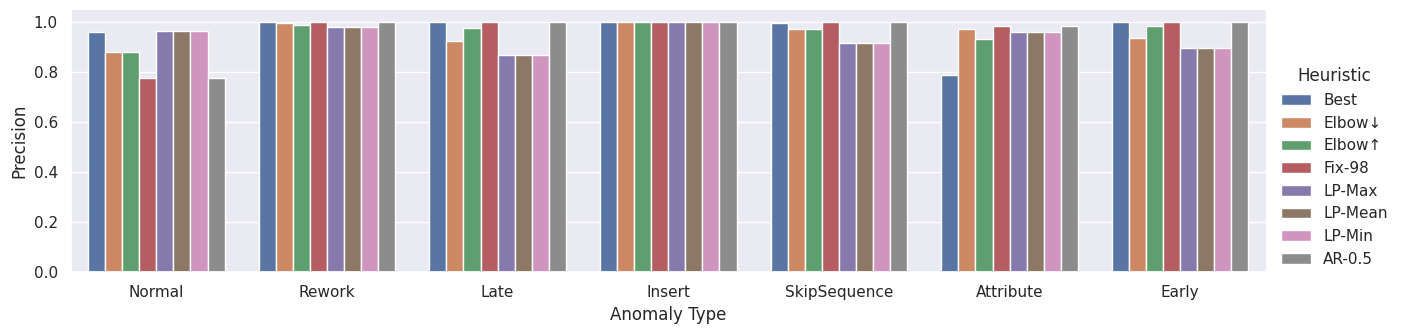

In [ ]:
color_palette = sns.color_palette()
df = anomalie_types_ratio.melt(var_name='Anomaly Type',value_name='Precision',id_vars ='Heuristic',value_vars=['Normal',
 'Rework',
 'Late',
 'Insert',
 'SkipSequence',
 'Attribute',
 'Early'],ignore_index=False)
g = sns.catplot(x="Anomaly Type", y="Precision",palette=color_palette,
                data=df, kind="bar",hue='Heuristic',
                height=3.5, aspect=3.7);
